This animation illustrates the occurence of pairwise combinations of gene knockouts when including an increasing number of plants in a plant library. Consider a multiplex CRISPR/Cas experiment targeting pairwise combinations of gene knockouts, characterized by the experimental design parameters listed in the file "DefaultParameters_k=2.jl".

Load packages

In [1]:
using Random; Random.seed!(1234) # Set a seed for reproducibility
using Plots, StatsPlots, StatsBase
using Distributions 
using LinearAlgebra
using Combinatorics


(process:37492): GLib-GIO-WARNING **: 17:43:23.610: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.2107.2.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs


Load default parameters and functions

In [17]:
include("MultiplexCrisprDOE.jl");
include("DefaultParameters_k=2.jl");

At a sample size of 24550, you know for 95% sure that the combinations you don't see are lethal.

In [33]:
function sampling_plants(n_plants)
    Random.seed!(1)
    X_interactions_count = zeros(x, x) # Initialize matrix to count pairwise interactions
    
    for plant in 1:n_plants     
                
        # sample combinatorial gRNA/Cas9 construct
        gRNA_indices_construct = findall((rand(Multinomial(r, p_gRNA_freq))) .!= 0)
                
        # execute mutations
        gRNA_indices_mutations = [gRNA for gRNA in gRNA_indices_construct if rand(Binomial(1, p_gRNA_edit[gRNA])) == 1]
            
        # effective gene knockout (loss-of-function) ?
        gRNA_indices_KO = [gRNA for gRNA in gRNA_indices_mutations if rand(Binomial(1, ϵ_KO)) == 1]
            
        # which genes are knocked out?
        genes_indices_KO = Int.(ceil.(gRNA_indices_KO / g))
            
        # which pairwise combinations are present?
        interactions = collect(combinations(genes_indices_KO, 2))
                
        # Store represented combinations in matrix
        for interaction in interactions
            j = interaction[1]; k = interaction[2]
            X_interactions_count[j,k] += 1; 
            X_interactions_count[k,j] += 1; 
            X_interactions_count[j,j] += 1; 
            X_interactions_count[k,k] += 1   
        
        end  
    end
    
    return X_interactions_count
end
 

sampling_plants (generic function with 1 method)

In [95]:
function heatmap_plant_sampling(interaction_matrix, n, x)
    
    return heatmap(interaction_matrix,   
    c=cgrad([:white, :white,
                :turquoise1, :turquoise1, :turquoise1,
                :turquoise4, :turquoise4, :turquoise4, 
                :blue3,  :blue3, :blue3,
                :blue4, :blue4  , :blue4 , 
                :blue4  , :blue4 , :blue4, :blue4, :blue4, :blue4,  
                :darkblue, :darkblue ]),
    clim=(0,10),
    xlabel="gene knockout 1
        ", ylabel="
        gene knockout 2", 
        title="Occurrence of pairwise combinations of gene knockouts 
     [plant library size = $n]
    
    ", 
        colorbar_title = "Times observed",
        xticks=(1:1:x, string.((1:1:x))),
        yticks=(1:1:x, string.((1:1:x))),

        size = (900,500))
    
end

heatmap_plant_sampling (generic function with 2 methods)

┌ Info: Saved animation to 
│   fn = C:\Users\kirst\OneDrive\Documenten\PhD\MultiplexCrisprDOE\sampling_plants.gif
└ @ Plots C:\Users\kirst\.julia\packages\Plots\YAlrZ\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\kirst\\OneDrive\\Documenten\\PhD\\MultiplexCrisprDOE\\sampling_plants.gif")
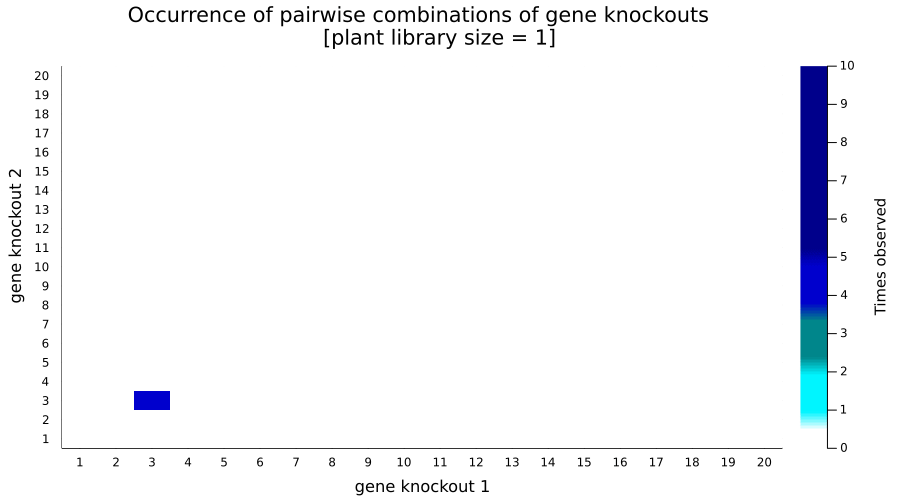

In [96]:
using Plots

collect
 
anim = @animate for n = vcat(collect(1:2:50), collect(50:5:2400))
    heatmap_plant_sampling(sampling_plants(n), n, x)
end
 
gif(anim, "sampling_plants.gif", fps = 5)